In [73]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [88]:
class Mamba(nn.Module):
    def __init__(self, B, L, D, N):
        super().__init__()
        self.B = B # Batch size
        self.L = L # Sequence length
        self.D = D # Model dimension
        self.N = N # State size
        
        self.W_d = nn.Parameter(torch.randn(D, D))
        self.b_d = nn.Parameter(torch.zeros(D))
        self.W_b = nn.Parameter(torch.randn(D, 2*N))
        self.W_c = nn.Parameter(torch.randn(D, 2*D))
        self.A = nn.Parameter(torch.randn(D, N))
        self.W_out = nn.Parameter(torch.randn(N, D))
        self.layer_norm = nn.LayerNorm(D)

    def delta_proj(self, x):
        return F.softplus(x @ self.W_d + self.b_d)

    def B_proj(self, x):
        return x @ self.W_b

    def C_proj(self, x):
        return x @ self.W_c

    def state_space_param(self, delta):
        return (1 - torch.exp(-delta)).unsqueeze(-1) * self.A

    def selective_scan(self, B, A_bar):
        batch_size, seq_len, _ = B.shape
        h_list = []
        h_prev = torch.zeros(batch_size, self.N, device=B.device)
        for l in range(seq_len):
            u = torch.sigmoid(B[:, l, :self.N])
            v = B[:, l, self.N:]
            h_l = u * (A_bar[:, l] @ h_prev.unsqueeze(-1)).squeeze(-1) + v
            h_list.append(h_l)
            h_prev = h_l
        return torch.stack(h_list, dim=1)

    def forward(self, x):
        B, L, D = x.shape
        assert B == self.B, f"Input batch size ({B}) doesn't match model batch size ({self.B})"
        assert L == self.L, f"Input sequence length ({L}) doesn't match model sequence length ({self.L})"
        assert D == self.D, f"Input dimension D ({D}) doesn't match model dimension ({self.D})"
        
        
        delta = self.delta_proj(x)
        B = self.B_proj(x)
        C = self.C_proj(x)
        
        A_bar = self.state_space_param(delta)
        
        h = self.selective_scan(B, A_bar)
        
        y = h @ self.W_out
        
        y = y * torch.sigmoid(C[:, :, :self.D]) + x * torch.sigmoid(C[:, :, self.D:])
        
        y = self.layer_norm(y)
        
        return y

In [89]:
batch_size = 1
sequence_len = 6
model_dim = 4
state_size = 4

model = Mamba(B=batch_size, L=sequence_len, D=model_dim, N=state_size)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

# sample input data
x = torch.tensor([[
    [1.0, 2.0, 3.0, 4.0],
    [5.0, 6.0, 7.0, 8.0],
    [9.0, 10.0, 11.0, 12.0],
    [13.0, 14.0, 15.0, 16.0],
    [17.0, 18.0, 19.0, 20.0],
    [21.0, 22.0, 23.0, 24.0]
]], dtype=torch.float32, requires_grad=True)

# sample target
target = torch.randn(1, 6, 4) 

In [90]:
epochs = 10000
losses = []

for epoch in range(epochs): 
    # Zero the parameter gradients
    optimizer.zero_grad()

    output = model(x)

    loss = criterion(output, target)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1000/10000], Loss: 0.2624
Epoch [2000/10000], Loss: 0.1936
Epoch [3000/10000], Loss: 0.1848
Epoch [4000/10000], Loss: 0.1827
Epoch [5000/10000], Loss: 0.1822
Epoch [6000/10000], Loss: 0.1821
Epoch [7000/10000], Loss: 0.1820
Epoch [8000/10000], Loss: 0.1853
Epoch [9000/10000], Loss: 0.1818
Epoch [10000/10000], Loss: 0.1819


In [91]:
with torch.no_grad():
    final_output = model(x)
    print("Final output:")
    print(final_output)

Final output:
tensor([[[ 0.7392, -0.6391,  0.3041,  0.5281],
         [-0.0544, -0.9829,  0.1728, -0.5722],
         [-0.5351,  0.5162,  0.2978,  0.5433],
         [-0.6365,  1.0048,  0.2551,  0.5894],
         [ 0.2350,  1.6509, -0.0564,  0.0706],
         [ 1.3268,  0.1314, -0.0919, -0.4022]]])


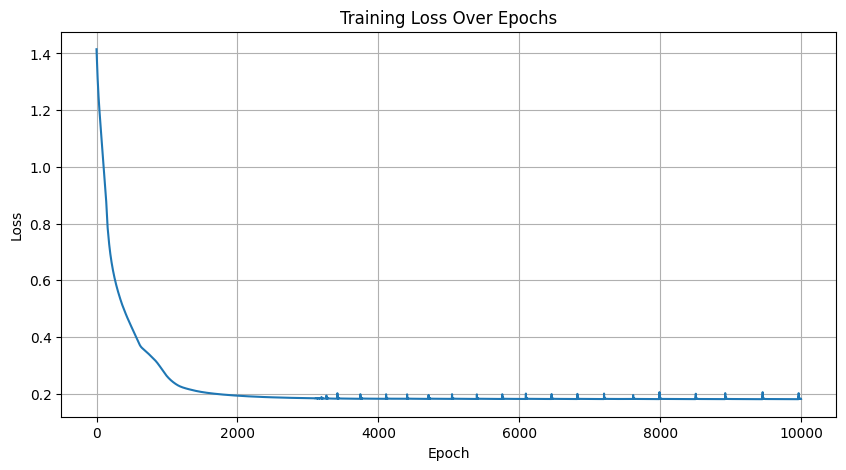

In [92]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()